In [ ]:
### Author: Leonie Küchenhoff
### Date: October 2022
### Purpose of script: Check how variants are annotated (intron vs. exon etc.), caluclate fraction per category, sample and tissue
###                     + Plot results

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy import stats
import os
from config import basedir, outdir, annotation_dir

In [2]:
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

In [3]:
# info for saving plots data directories
max_events_in_region = '2'
os.chdir(basedir)
outdir = str(outdir + '/annotation/')
annodir = annotation_dir
print('This base directory will be used:\n', basedir)
os.chdir(basedir)

This base directory will be used:
 /g/steinmetz/project/leonie_crispr/03_data/01_heartproject/snakemake_vcf/


In [4]:
# define filtering method
# 2ed:  Use variants that were called by 2 variant callers & have at least 5 reads in all tissues & have at least 2 alternative allels called across all tissues
filter = '2ed'
names = ['279', '282', '450']
groups = ['somatic', 'germline']
col1 = 'ad_h'
col2 = 'ad_l'
col3 = 'ad_t'

In [5]:
# paths to input files
paths_som = [f'merged/txt_files/ad_hc_mu/HLT{i}.specific.txt' for i in names]
paths_germ = [f'merged/txt_files/ad_hc_mu/HLT{i}.tisoverlap.txt' for i in names]
paths_anno = [f'{annodir}/HLT{i}.merged.mm10_multianno.txt' for i in names]


In [6]:
# limit columns to read in
use_cols = ['Func.refGene', 'Gene.refGene',
       'GeneDetail.refGene', 'ExonicFunc.refGene', 
       'AAChange.refGene','Otherinfo4', 
       'Otherinfo5', 'Otherinfo7', 'Otherinfo8']

In [40]:
# read in data and save in dictionary format for easy accessing throughout the script
somatic_dict = {}
germline_dict = {}
unknown_three_dict = {}
known_three_dict = {}
three_dict = {}
for i in zip(paths_som,paths_germ, paths_anno, names):
    som = pd.read_csv(i[0], delimiter = '\t')
    germ = pd.read_csv(i[1], delimiter = '\t')
    anno = pd.read_csv(i[2], delimiter = '\t', usecols = use_cols).rename(
        columns={
            'Otherinfo4':'chr', 
            'Otherinfo5':'pos', 
            'Otherinfo7':'ref', 
            'Otherinfo8':'alt'}
        )
    som_merged = pd.merge(som, anno, how = 'left',on = ['chr', 'pos', 'ref', 'alt'])
    germ_merged = pd.merge(germ, anno, how = 'left',on = ['chr', 'pos', 'ref', 'alt'])
    somatic_dict[i[3]] = som_merged[(som_merged['chr'] != 'chrX') & (som_merged['chr'] != 'chrY')]
    germline = germ_merged[(germ_merged['chr'] != 'chrX') & (germ_merged['chr'] != 'chrY')]
    germline_dict[i[3]] = germline

In [41]:
def snp_stats_table(df_som):
    '''
    function to get the summary statistics on where variants
    were measured how many times (i.e. in exons, introns, etc.)
    '''
    df_c = df_som.copy()

    # rename columns for plot
    # (certain categories are grouped together, such as UTR3 and UTR5)
    df_c.loc[df_c['Func.refGene'] == 'UTR3', 'Func.refGene']= f'UTR3/5'
    df_c.loc[df_c['Func.refGene'] == 'UTR5', 'Func.refGene']= f'UTR3/5'
    df_c.loc[df_c['Func.refGene'] == 'UTR5;UTR3', 'Func.refGene']= f'UTR3/5'
    df_c.loc[df_c['Func.refGene'] == 'downstream', 'Func.refGene']= f'intergenic'
    df_c.loc[df_c['Func.refGene'] == 'upstream', 'Func.refGene']= f'intergenic'
    df_c.loc[df_c['Func.refGene'] == 'upstream;downstream', 'Func.refGene']= f'intergenic'
    df_c.loc[df_c['Func.refGene'] == 'ncRNA_exonic', 'Func.refGene']= f'exonic'
    df_c.loc[df_c['Func.refGene'] == 'ncRNA_intronic', 'Func.refGene']= f'intronic'
    df_c.loc[df_c['Func.refGene'] == 'ncRNA_splicing', 'Func.refGene']= f'exonic'
    df_c.loc[df_c['Func.refGene'] == 'splicing', 'Func.refGene']= f'exonic' 
    df_c.loc[df_c['Func.refGene'] == 'exonic;splicing', 'Func.refGene']= f'exonic'


    # count snps per sample & separate tissues
    heart_spec = df_c[df_c['heart']]
    liver_spec = df_c[df_c['liver']]
    tail_spec = df_c[df_c['tail']]
    heartcount = heart_spec.groupby('Func.refGene').count()['heart']
    livercount = liver_spec.groupby('Func.refGene').count()['liver']
    tailcount = tail_spec.groupby('Func.refGene').count()['tail']

    # summarize snp counts into one table (can only merge two tables at once, hence merge in two steps)
    summary = pd.merge(heartcount, livercount, how = 'outer', left_index= True, right_index = True)
    summary = pd.merge(summary, tailcount, how = 'outer', left_index= True, right_index = True)

    # caluclate relative contributions per snp for each sample
    fractions = summary.div(summary.sum(axis=0), axis=1)

    # reformat table for easier plotting
    fractions['location'] = fractions.index

    # reformat table for easier plotting
    fractions_plot = pd.melt(fractions, id_vars=['location'])
    fractions_plot.loc[fractions_plot['variable'] == 'alt', 'variable'] = 'heart & liver'

    return fractions_plot, summary


In [42]:

def snp_stats_table_germline(df_germ):
    '''
    function to get the summary statistics on where variants
    were measured how many times (i.e. in exons, introns, etc.)
    '''

    df_g = df_germ.copy()

    # rename columns for plot
    # (certain categories are grouped together, such as UTR3 and UTR5)
    df_g.loc[df_g['Func.refGene'] == 'UTR3', 'Func.refGene']= f'UTR3/5'
    df_g.loc[df_g['Func.refGene'] == 'UTR5', 'Func.refGene']= f'UTR3/5'
    df_g.loc[df_g['Func.refGene'] == 'UTR5;UTR3', 'Func.refGene']= f'UTR3/5'
    df_g.loc[df_g['Func.refGene'] == 'downstream', 'Func.refGene']= f'intergenic'
    df_g.loc[df_g['Func.refGene'] == 'upstream', 'Func.refGene']= f'intergenic'
    df_g.loc[df_g['Func.refGene'] == 'upstream;downstream', 'Func.refGene']= f'intergenic'
    df_g.loc[df_g['Func.refGene'] == 'ncRNA_exonic', 'Func.refGene']= f'exonic'
    df_g.loc[df_g['Func.refGene'] == 'ncRNA_intronic', 'Func.refGene']= f'intronic'
    df_g.loc[df_g['Func.refGene'] == 'ncRNA_splicing', 'Func.refGene']= f'exonic'
    df_g.loc[df_g['Func.refGene'] == 'splicing', 'Func.refGene']= f'exonic' 
    df_g.loc[df_g['Func.refGene'] == 'exonic;splicing', 'Func.refGene']= f'exonic'


    # count types in germline variant files (colums used here are of no meaning)
    germcount_three = df_g.groupby('Func.refGene').count()['pos']

    # caluclate relative contributions per snp for each sample
    fractions = germcount_three.to_frame().div(germcount_three.to_frame().sum(axis=0), axis=1)

    # reformat table for easier plotting
    fractions['location'] = fractions.index

    # reformat table for easier plotting
    fractions_plot = pd.melt(fractions, id_vars=['location'])
    fractions_plot.loc[fractions_plot['variable'] == 'pos','variable'] = 'tis. overlap'

    return fractions_plot, germcount_three

In [43]:
# calculate fractions and strore results in shape of dictionary
fractions_dict = {}
summary_dict = {}
fractions_dict_germ = {}
summary_dict_germ = {}

for i in names:
    fractions_dict[i], summary_dict[i] = snp_stats_table(df_som = somatic_dict[i])

for i in names:
    fractions_dict_germ[i], summary_dict_germ[i] = snp_stats_table_germline(germline_dict[i])

In [44]:
#plotting settings
colors = [sns.color_palette('colorblind')[3],
          sns.color_palette('colorblind')[2],
          sns.color_palette('colorblind')[0],
          'white',
          sns.color_palette('colorblind')[7]]
costum_palette = sns.color_palette(colors)

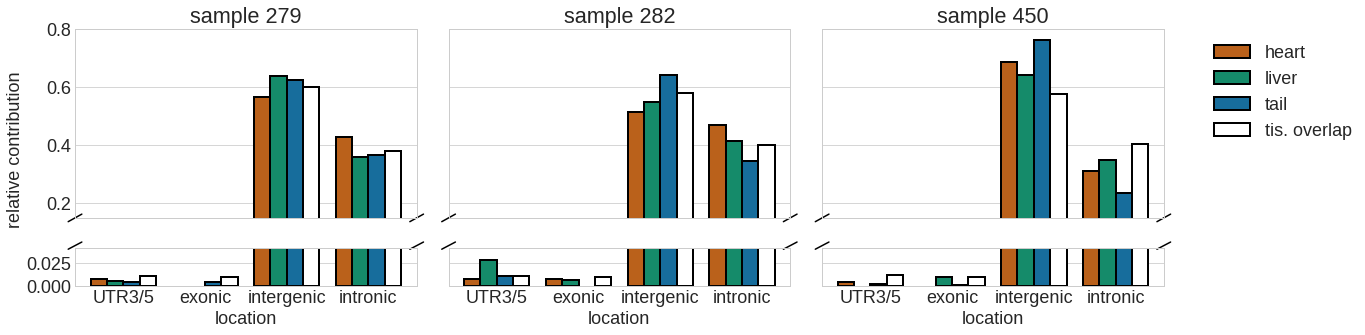

In [45]:
# Plot samples separately

fig, ax = plt.subplots(2,3, figsize = (19,5), sharey = 'row', sharex = True, gridspec_kw= {'height_ratios': [5,1]})
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
for count, i in enumerate(names):
    subset = fractions_dict[i][fractions_dict[i]['variable'].isin(['heart', 'liver', 'tail', 'heart & liver'])]
    fractions_stats = pd.concat([subset, fractions_dict_germ[i]])
    fractions_stats = fractions_stats[fractions_stats['variable'].isin(['heart', 'liver', 'heart & liver', 'tail', 'tis. overlap'])]

    sns.barplot(x = 'location',y = 'value', hue = 'variable', ax = ax[0, count], data = fractions_stats, 
                palette = costum_palette, edgecolor = 'black', linewidth = 2, order = ['UTR3/5', 'exonic', 'intergenic', 'intronic'])
    sns.barplot(x = 'location',y = 'value', hue = 'variable', ax = ax[1, count], data = fractions_stats, 
                palette = costum_palette, edgecolor = 'black', linewidth = 2, order = ['UTR3/5', 'exonic', 'intergenic', 'intronic'])
    ax[0,count].set_ylabel('')
    ax[1,count].set_ylabel('')
    ax[0,count].set_title(f'sample {i}')
    ax[0,count].get_xaxis().set_visible(False)

    d = .02  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax[0,count].transAxes, color="k", clip_on=False)
    ax[0,count].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax[0,count].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax[1,count].transAxes)  # switch to the bottom axes
    ax[1,count].plot((-d, +d), (1 - d,1.15 + d), **kwargs)  # bottom-left diagonal
    ax[1,count].plot((1 - d, 1 + d), (1 - d, 1.15+ d), **kwargs)  # bottom-right diagonal

fig.text(0, 0.55, "relative contribution", va="center", rotation="vertical")
ax[0,0].set_ylim(0.15,0.8)
ax[1,0].set_ylim(0,0.04)
ax[0,0].get_legend().remove()
ax[0,1].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()
ax[1,2].get_legend().remove()
ax[0,2].legend(bbox_to_anchor = (1.1,1))
fig.tight_layout()
plt.show()

#save plot and plotted data in table

#fig.savefig(f'{outdir}/annotation/filter2ad/rel_contribution_{filter}_all.pdf', bbox_inches = 'tight')
#fig.savefig(f'{outdir}/annotation/filter2ad/rel_contribution_{filter}_all.svg', bbox_inches = 'tight')


In [49]:
# summarize data in one table

summary = summary_dict['279'].add(summary_dict['282'], fill_value = 0).add(summary_dict['450'], fill_value = 0).fillna(0)
summary_germ = summary_dict_germ['279'].add(summary_dict_germ['282'], fill_value = 0).add(summary_dict_germ['450'], fill_value = 0).fillna(0)

full_absolute = pd.merge(summary, summary_germ, how = 'outer', left_index = True, right_index = True)
full_absolute = full_absolute.rename(columns = {'pos': 'tis. overlap'})
full_frations = full_absolute.div(full_absolute.sum(axis=0), axis=1).reset_index()
plot = full_frations.melt(id_vars = 'Func.refGene')
plot = plot[plot['variable'].isin(['heart', 'liver', 'tail', 'tis. overlap'])]

In [50]:
# save raw data
for i in names:
    save = summary_dict[i].fillna(0)
    save = pd.merge(save, summary_dict_germ[i], how = 'outer', left_index = True, right_index = True).rename(columns = {'pos':'tis. overlap'})
    #save.to_csv(f'{outdir}/annotation/filter2ad/{filter}_{i}_absolute_numbers.txt', sep = '\t', index = True)

              heart  liver  tail  tis. overlap
Func.refGene                                  
UTR3/5          3.0    1.0     2         11927
exonic          0.0    0.0     2         10181
intergenic    209.0  123.0   274        649017
intronic      158.0   69.0   161        409075
              heart  liver   tail  tis. overlap
Func.refGene                                   
UTR3/5            1      4    9.0         11534
exonic            1      1    0.0          9773
intergenic       67     78  508.0        587510
intronic         61     59  274.0        405372
              heart  liver  tail  tis. overlap
Func.refGene                                  
UTR3/5          1.0    0.0     2         11941
exonic          0.0    3.0     1          9936
intergenic    158.0  186.0   553        580316
intronic       72.0  102.0   171        408102


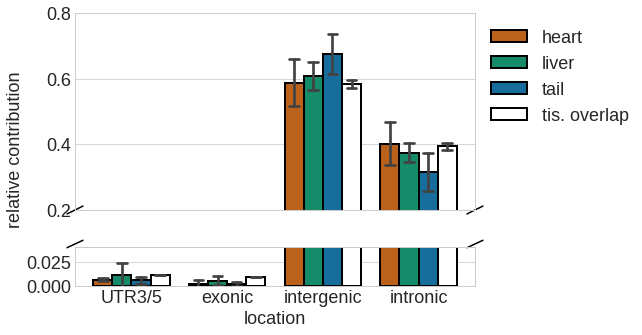

In [51]:
#Plot samples in one plot

fractions_stats = pd.concat([fractions_dict['279'], fractions_dict['282'],fractions_dict['450']], keys = ['279', '282', '450', 'germline'])
subset = fractions_stats[fractions_stats['variable'].isin(['heart', 'liver', 'tail', 'heart & liver'])]

fractions_stats = pd.concat([fractions_dict_germ['279'], fractions_dict_germ['282'],fractions_dict_germ['450']], keys = ['279', '282', '450', 'germline'])
plot = pd.concat([subset, fractions_stats])

plot = plot[plot['variable'].isin(['heart', 'liver', 'tail', 'tis. overlap'])].fillna(0)


fig, ax = plt.subplots(2,1, figsize = (9,5), sharex = True, gridspec_kw= {'height_ratios': [5,1]})
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x = 'location',y = 'value', hue = 'variable', data = plot, capsize = 0.1, ci = 'sd', ax = ax[0], 
            palette = costum_palette, edgecolor = 'black', linewidth = 2, order = ['UTR3/5', 'exonic', 'intergenic', 'intronic'])
sns.barplot(x = 'location',y = 'value', hue = 'variable', data = plot, capsize = 0.1, ci = 'sd', ax = ax[1], 
            palette = costum_palette, edgecolor = 'black', linewidth = 2, order = ['UTR3/5', 'exonic', 'intergenic', 'intronic'])

ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].get_xaxis().set_visible(False)

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color="k", clip_on=False)
ax[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
ax[1].plot((-d, +d), (1 - d,1.15 + d), **kwargs)  # bottom-left diagonal
ax[1].plot((1 - d, 1 + d), (1 - d, 1.15+ d), **kwargs)  # bottom-right diagonal

ax[0].set_ylim(0.2,0.8)
ax[1].set_ylim(0,0.04)
ax[1].get_legend().remove()
ax[0].set_xlabel('SNV')
ax[0].set_ylabel('')

fig.text(0, 0.55, "relative contribution", va="center", rotation="vertical")
#ax.set_title(f'SNVs')

ax[0].legend(bbox_to_anchor = (1.0, 1))
fig.tight_layout()
plt.show()

#save plot and plotted data in table

#fig.savefig(f'{outdir}/annotation/filter2ad/rel_contribution_{filter}_all_sd.pdf', bbox_inches = 'tight')
#fig.savefig(f'{outdir}/annotation/filter2ad/rel_contribution_{filter}_all_sd.svg', bbox_inches = 'tight')
#plot.rename(columns = {'variable':'tissue', 'value':'proportion_per_sample_and_tissue'}).to_csv(f'{outdir}/annotation/filter2ad/{filter}_table.csv', index_label = ['sample', 'index'])

In [52]:
# test significance and save significant pairs in list

test = plot.reset_index()
grouped = test.groupby(['location','variable'])
#fractions = np.zeros((15, 3))
loc_dict = {}
for j in ['UTR3/5', 'exonic', 'intergenic', 'intronic']:
    fractions = np.zeros((4, 3))
    for count,i in enumerate(['heart', 'liver','tail', 'tis. overlap']):
        fractions[count] = grouped.get_group((j , i))['value']
    loc_dict[j] = np.nan_to_num(fractions,0)

pvalue_dict = {}
for x in ['UTR3/5', 'exonic', 'intergenic', 'intronic']:
    p_values = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            p_values[i,j] = stats.ttest_ind(a = loc_dict[x][i], b = loc_dict[x][j], equal_var = False)[1]
    pvalue_dict[x] = p_values

list = []

name_dict = {}
for count,i in enumerate(['heart', 'liver','tail', 'tis. overlap']):
    name_dict[count] = i

for key, i in  pvalue_dict.items():
    row, col = np.where(i<0.05)
    orderd_indexlist = []
    for i in zip(row, col):
        first = (np.array(i).min())
        second = (np.array(i).max())
        orderd_indexlist +=[(first,second)]
    for x,y in np.unique(np.array(orderd_indexlist), axis = 0):
            list += [((key, name_dict[x]), (key, name_dict[y]))]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

exonic_tail vs. exonic_tis. overlap: Welch's t-test independent samples, P_val:2.889e-02 t=-5.652e+00


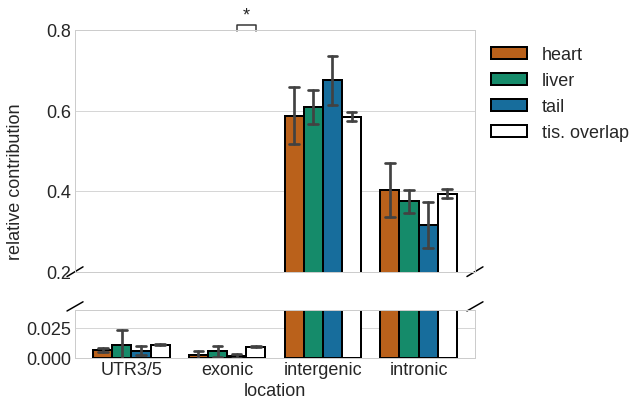

In [54]:
# Add significance asterics to plot

fig, ax = plt.subplots(2,1, figsize = (9,6), sharex = True, gridspec_kw= {'height_ratios': [5,1]})
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x = 'location',y = 'value', hue = 'variable', data = plot, capsize = 0.1, ci = 'sd', ax = ax[0], 
            palette = costum_palette, edgecolor = 'black', linewidth = 2,)
sns.barplot(x = 'location',y = 'value', hue = 'variable', data = plot, capsize = 0.1, ci = 'sd', ax = ax[1], 
            palette = costum_palette, edgecolor = 'black', linewidth = 2,)

pairs = list
annot = Annotator(None, pairs)
annot.new_plot(ax = ax[0], x = 'location',y = 'value', hue = 'variable', data = plot, seed=2021)
annot.configure(test='t-test_welch', text_format='star', loc='outside',verbose=2)
annot.apply_test().annotate()


ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[0].get_xaxis().set_visible(False)
d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax[0].transAxes, color="k", clip_on=False)
ax[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax[1].transAxes)  # switch to the bottom axes
ax[1].plot((-d, +d), (1 - d,1.15 + d), **kwargs)  # bottom-left diagonal
ax[1].plot((1 - d, 1 + d), (1 - d, 1.15+ d), **kwargs)  # bottom-right diagonal


ax[0].set_ylim(0.2,0.8)
ax[1].set_ylim(0,0.04)
ax[1].get_legend().remove()
ax[0].set_xlabel('SNV')
ax[0].set_ylabel('')

fig.text(0, 0.55, "relative contribution", va="center", rotation="vertical")
ax[0].legend(bbox_to_anchor = (1, 1), loc = 'upper left')
fig.tight_layout()
plt.show()

#save plot

#fig.savefig(f'{outdir}/annotation/filter2d/rel_contribution_{filter}_all_sd_ttest.pdf', bbox_inches = 'tight')
#fig.savefig(f'{outdir}/annotation/filter2d/rel_contribution_{filter}_all_sd_ttest.svg', bbox_inches = 'tight')